In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# Cargar datos
DATA_DIR = Path("../data/raw")
train_values = pd.read_csv(DATA_DIR / "train_values.csv", index_col="building_id")
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv", index_col="building_id")
test_values = pd.read_csv(DATA_DIR / "test_values.csv", index_col="building_id")

print(f"Train: {train_values.shape}, Test: {test_values.shape}")

Train: (260601, 38), Test: (86868, 38)


In [2]:
def create_features(df):
    """
    Crear features basadas en el EDA.
    """
    df = df.copy()
    
    # ============ VULNERABILIDAD DE MATERIALES ============
    
    # Materiales débiles (MÁS daño)
    weak_materials = [
        'has_superstructure_mud_mortar_stone',
        'has_superstructure_stone_flag',
        'has_superstructure_adobe_mud',
        'has_superstructure_mud_mortar_brick',
        'has_superstructure_bamboo'
    ]
    df['weak_material_count'] = df[weak_materials].sum(axis=1)
    
    # Materiales fuertes (MENOS daño)
    strong_materials = [
        'has_superstructure_rc_engineered',
        'has_superstructure_rc_non_engineered',
        'has_superstructure_cement_mortar_brick',
        'has_superstructure_cement_mortar_stone'
    ]
    df['strong_material_count'] = df[strong_materials].sum(axis=1)
    
    # Índice de vulnerabilidad
    df['vulnerability_score'] = df['weak_material_count'] - df['strong_material_count']
    
    # ============ CARACTERÍSTICAS ESTRUCTURALES ============
    
    # Edificios altos son más vulnerables
    df['age_x_floors'] = df['age'] * df['count_floors_pre_eq']
    
    # Ratio altura/área
    df['height_area_ratio'] = df['height_percentage'] / (df['area_percentage'] + 1)
    
    # Familias por piso (densidad)
    df['families_per_floor'] = df['count_families'] / (df['count_floors_pre_eq'] + 1)
    
    # ============ CATEGORÍAS DE EDAD ============
    
    df['is_old'] = (df['age'] > 25).astype(int)
    df['is_very_old'] = (df['age'] > 50).astype(int)
    
    # ============ TOTAL SUPERSTRUCTURE ============
    
    superstructure_cols = [col for col in df.columns if 'has_superstructure' in col]
    df['total_superstructure_types'] = df[superstructure_cols].sum(axis=1)
    
    # ============ SECONDARY USE ============
    
    secondary_cols = [col for col in df.columns if 'has_secondary_use_' in col]
    df['total_secondary_uses'] = df[secondary_cols].sum(axis=1)
    
    # ============ GEOGRAPHIC ============
    
    # Regiones de alto riesgo (del EDA)
    high_risk_regions = [17, 18, 21, 8, 27, 28]
    df['is_high_risk_region'] = df['geo_level_1_id'].isin(high_risk_regions).astype(int)
    
    # Regiones de bajo riesgo
    low_risk_regions = [26, 24, 5, 20, 13, 1]
    df['is_low_risk_region'] = df['geo_level_1_id'].isin(low_risk_regions).astype(int)
    
    return df

# Aplicar
train_fe = create_features(train_values)
test_fe = create_features(test_values)

print(f"Features originales: {train_values.shape[1]}")
print(f"Features después de engineering: {train_fe.shape[1]}")
print(f"\nNuevas features creadas:")
new_cols = [col for col in train_fe.columns if col not in train_values.columns]
print(new_cols)

Features originales: 38
Features después de engineering: 50

Nuevas features creadas:
['weak_material_count', 'strong_material_count', 'vulnerability_score', 'age_x_floors', 'height_area_ratio', 'families_per_floor', 'is_old', 'is_very_old', 'total_superstructure_types', 'total_secondary_uses', 'is_high_risk_region', 'is_low_risk_region']


In [3]:
# Ver correlación de las nuevas features
train_fe_with_target = train_fe.join(train_labels)

new_features = [
    'weak_material_count',
    'strong_material_count', 
    'vulnerability_score',
    'age_x_floors',
    'height_area_ratio',
    'families_per_floor',
    'is_old',
    'is_very_old',
    'total_superstructure_types',
    'is_high_risk_region',
    'is_low_risk_region'
]

correlations = train_fe_with_target[new_features].corrwith(
    train_fe_with_target['damage_grade']
).sort_values(ascending=False)

print("📊 Correlación de nuevas features con damage_grade:\n")
print(correlations)

📊 Correlación de nuevas features con damage_grade:

is_high_risk_region           0.362784
vulnerability_score           0.319986
weak_material_count           0.245382
height_area_ratio             0.118631
is_old                        0.116059
is_very_old                   0.049183
age_x_floors                  0.034444
families_per_floor           -0.026378
total_superstructure_types   -0.032980
strong_material_count        -0.307971
is_low_risk_region           -0.332391
dtype: float64


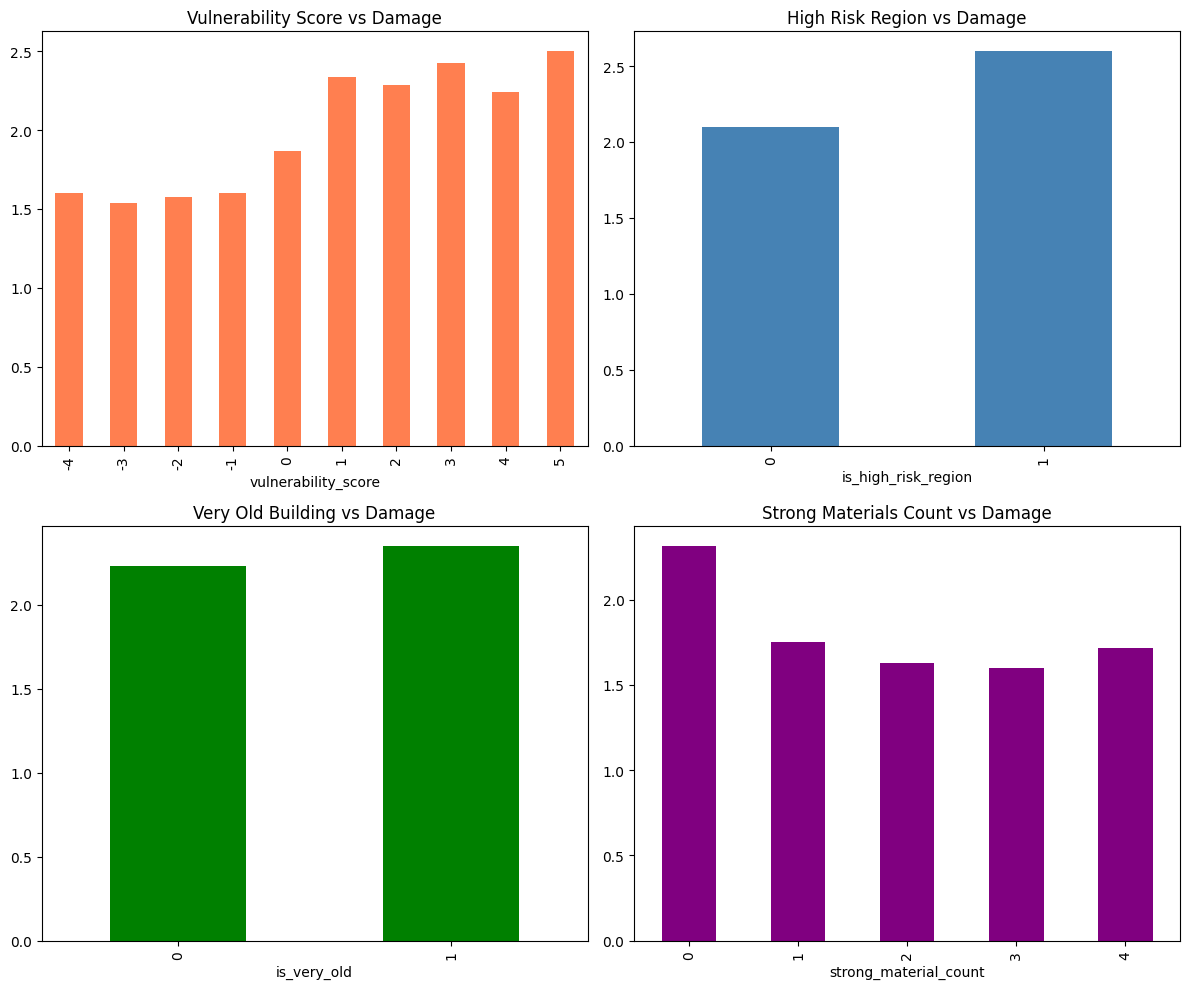

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Vulnerability score vs damage
train_fe_with_target.groupby('vulnerability_score')['damage_grade'].mean().plot(
    kind='bar', ax=axes[0,0], title='Vulnerability Score vs Damage', color='coral'
)

# High risk region vs damage
train_fe_with_target.groupby('is_high_risk_region')['damage_grade'].mean().plot(
    kind='bar', ax=axes[0,1], title='High Risk Region vs Damage', color='steelblue'
)

# Age categories vs damage  
train_fe_with_target.groupby('is_very_old')['damage_grade'].mean().plot(
    kind='bar', ax=axes[1,0], title='Very Old Building vs Damage', color='green'
)

# Strong materials vs damage
train_fe_with_target.groupby('strong_material_count')['damage_grade'].mean().plot(
    kind='bar', ax=axes[1,1], title='Strong Materials Count vs Damage', color='purple'
)

plt.tight_layout()
plt.show()